In [1]:
import os
import glob
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import matplotlib as mpl
from artifactremoval.imgproc import npy_to_sitk
from scipy.ndimage import zoom

# -- CONFIGURE YOUR BASE DIRECTORY HERE --
base_dir = r"E:\ArtifactRemovalProject\data\modelinference"


In [ ]:
# Prepare a mutable “turbo” colormap
cmap = mpl.cm.get_cmap("turbo").copy()
cmap.set_under('black')

# Iterate through subject/date subfolders
for subj_dir in glob.glob(os.path.join(base_dir, "*")) :
    if not os.path.isdir(subj_dir):
        continue
    for date_dir in glob.glob(os.path.join(subj_dir, "*")):
        if not os.path.isdir(date_dir):
            continue

        # File paths
        chonaa_path = os.path.join(date_dir, "chonaa.nii.gz")
        t1_path     = os.path.join(date_dir, "t1.nii.gz")
        s_pred_path = os.path.join(date_dir, "ypred_saumya.npy")
        m_pred_path = os.path.join(date_dir, "preds_vol_all_four.npy")
        qmap_path   = os.path.join(date_dir, "qmap.npy")        

        # Load images & arrays
        moving_img     = sitk.ReadImage(chonaa_path)
        fixed_img      = sitk.ReadImage(t1_path)
        raw_chonaa_arr = sitk.GetArrayFromImage(moving_img)
        t1_arr         = sitk.GetArrayFromImage(fixed_img)
        s_pred_arr     = np.load(s_pred_path)[..., 1]
        s_pred_arr     = (s_pred_arr > 0.5).astype(np.uint8)
        m_pred_arr     = np.load(m_pred_path)
        qmap_arr       = np.load(qmap_path)
        qmap_1         = (qmap_arr >= 1).astype(np.uint8)                        
        qmap_2         = (qmap_arr >= 2).astype(np.uint8)
        qmap_4         = (qmap_arr == 4).astype(np.uint8)
        print("loaded")

        # Count Acceptable Voxels in each Mask
        raw_count          = np.count_nonzero(qmap_1 == 1, axis=(1, 2)).reshape(-1, 1)
        s_pred_arr_count   = np.count_nonzero(s_pred_arr == 1, axis=(1, 2)).reshape(-1, 1)
        m_pred_arr_count   = np.count_nonzero(m_pred_arr == 1, axis=(1, 2)).reshape(-1, 1)
        qmap_2_count       = np.count_nonzero(qmap_2 == 1, axis=(1, 2)).reshape(-1, 1)
        qmap_4_count       = np.count_nonzero(qmap_4 == 1, axis=(1, 2)).reshape(-1, 1)

        # 1) Create centered transform from moving→fixed
        transform = sitk.CenteredTransformInitializer(
            fixed_img,
            moving_img,
            sitk.Euler3DTransform(),
            sitk.CenteredTransformInitializerFilter.GEOMETRY
        )
        transform = sitk.Transform(transform)

        # 2) Convert raw & predictions back to SITK
        y0 = moving_img
        y1 = npy_to_sitk(raw_chonaa_arr * s_pred_arr, y0)
        y2 = npy_to_sitk(raw_chonaa_arr * m_pred_arr, y0)
        y3 = npy_to_sitk(raw_chonaa_arr * qmap_2, y0)
        y4 = npy_to_sitk(raw_chonaa_arr * qmap_4, y0)

        # 3) Resample each into T1 space
        y0_r = sitk.Resample(y0, fixed_img, transform, sitk.sitkLinear, 0.0, y0.GetPixelID())
        y1_r = sitk.Resample(y1, fixed_img, transform, sitk.sitkLinear, 0.0, y1.GetPixelID())
        y2_r = sitk.Resample(y2, fixed_img, transform, sitk.sitkLinear, 0.0, y2.GetPixelID())
        y3_r = sitk.Resample(y3, fixed_img, transform, sitk.sitkLinear, 0.0, y3.GetPixelID())
        y4_r = sitk.Resample(y4, fixed_img, transform, sitk.sitkLinear, 0.0, y4.GetPixelID())
        print("resampled")

        # 4) Back to NumPy arrays
        base_arr   = sitk.GetArrayFromImage(y0_r)
        saumya_arr = sitk.GetArrayFromImage(y1_r)
        mine_arr   = sitk.GetArrayFromImage(y2_r)
        qmap2_arr  = sitk.GetArrayFromImage(y3_r)
        qmap4_arr  = sitk.GetArrayFromImage(y4_r)

        scale = raw_count.shape[0] / base_arr.shape[0]   
        lookup = np.rint(np.arange(base_arr.shape[0]) * scale).astype(int)

        # Precompute window/level for T1
        vmin_t1, vmax_t1 = np.percentile(t1_arr, [1, 99])
        vmin_o, vmax_o   = 0, 1.5

        output_dir = os.path.join(date_dir, "images")

        # Make sure output folder exists
        os.makedirs(output_dir, exist_ok=True)

        # 5) Loop a subset of slices and save PNGs
        for j in range(30, 140, 5):
            n_base = int(raw_count[lookup[j], 0])  
            n_s = int(s_pred_arr_count[lookup[j], 0])  
            n_m = int(m_pred_arr_count[lookup[j], 0])  
            n_q2 = int(qmap_2_count[lookup[j], 0])  
            n_q4 = int(qmap_4_count[lookup[j], 0])  

            anat   = t1_arr[j]
            base   = np.ma.masked_where(base_arr[j]   <= 0, base_arr[j])
            saumya = np.ma.masked_where(saumya_arr[j] <= 0, saumya_arr[j])
            mine   = np.ma.masked_where(mine_arr[j]   <= 0, mine_arr[j])
            q2     = np.ma.masked_where(qmap2_arr[j] <=0, qmap2_arr[j])
            q4     = np.ma.masked_where(qmap4_arr[j] <=0, qmap4_arr[j])

            fig, axes = plt.subplots(1, 5, figsize=(12, 4), facecolor='black')
            for ax in axes:
                ax.set_facecolor('black')
                ax.axis('off')

            titles = [
                f"Slice {j}\n{n_base} voxels total",
                f"QMAP >= 2 \n{n_q2} voxels",
                f"QMAP = 4 \n{n_q4} voxels",
                f"Saumya CNN \n{n_s} voxels",
                f"New CNN \n{n_m} voxels",
            ]

            print("making figures")
            for ax, overlay, title in zip(axes, (base, q2, q4, saumya, mine), titles):
                # Underlay T1
                ax.imshow(anat,
                          cmap='gray',
                          vmin=vmin_t1,
                          vmax=vmax_t1,
                          interpolation='nearest')
                # Overlay Cho/NAA
                ax.imshow(overlay,
                          cmap=cmap,
                          alpha=0.7,
                          vmin=vmin_o,
                          vmax=vmax_o,
                          interpolation='nearest')
                ax.set_title(title, color='white', fontsize=10)

            plt.tight_layout(pad=0.3)
            out_name = os.path.join(output_dir, f"slice_{j:03d}_comparison2.png")
            fig.savefig(out_name,
                        dpi=300,
                        facecolor='black',
                        bbox_inches='tight',
                        pad_inches=0)
            plt.close(fig)

print("All subjects processed and images saved.")


loaded
resampled
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
loaded
resampled
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
loaded
resampled
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
maki

Total candidates found: 87 voxels


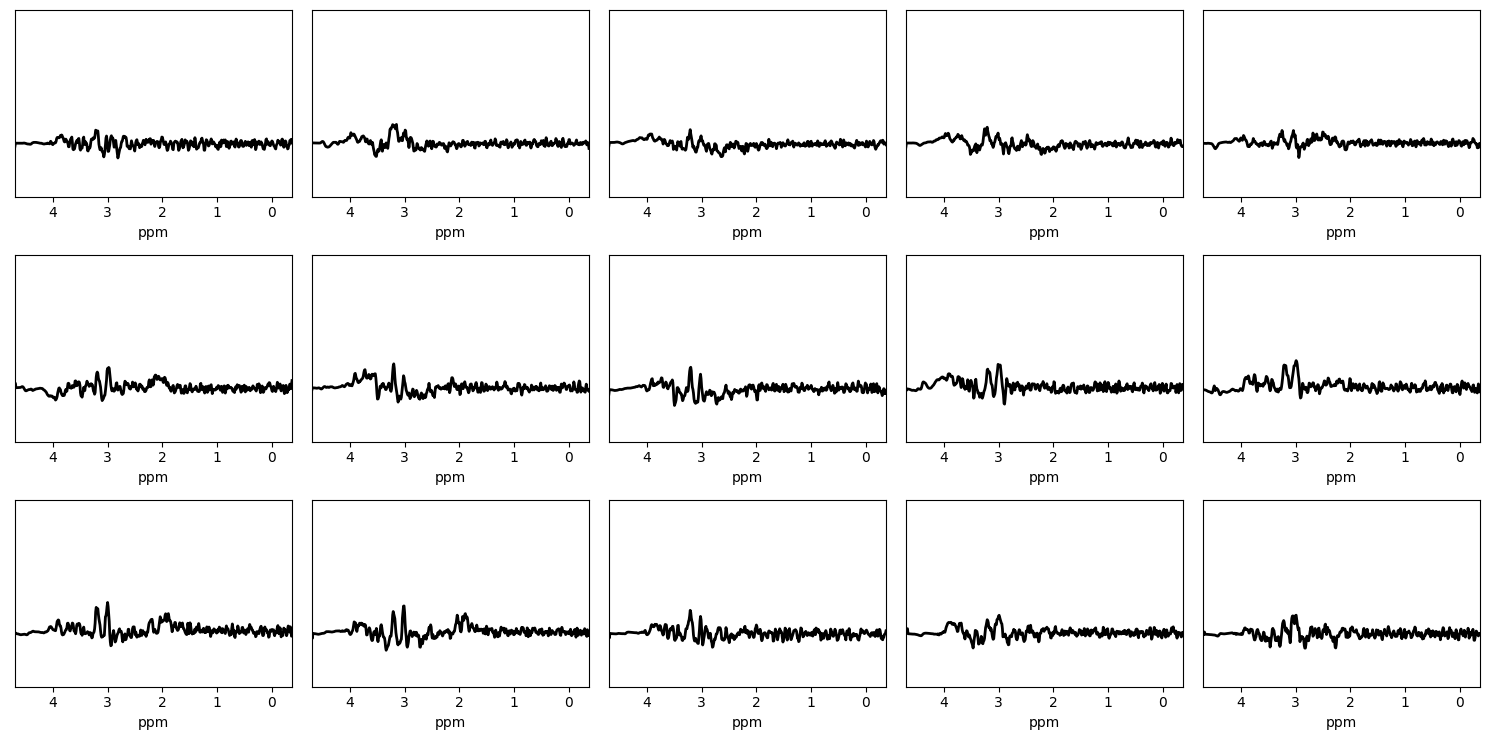

In [ ]:
import json
from pathlib import Path

basedir = Path("E:\ArtifactRemovalProject\data\modelinference")
input_dir = basedir / "rGBM_001_02_27_2023" / "02.27.2023"


chonaapath = input_dir / "chonaa.nii.gz"
mypredspath = input_dir / "preds_vol_all_four.npy"
spredspath = input_dir / "ypred_saumya.npy"
specarrpath = input_dir / "si.npy"

chonaa = sitk.ReadImage(chonaapath)
chonaa_arr = sitk.GetArrayFromImage(chonaa)
m_mask_arr = np.load(mypredspath)
s_mask_arr = np.load(spredspath)[:,:,:,1]
s_mask_bin = (s_mask_arr >= 0.5).astype(np.uint8)
spectral_arr = np.load(specarrpath)

# --- Load averaged sampling info from JSON ---
with open("avg_spectral_sampling.json", "r") as f:
    spec_sample = json.load(f)

# --- Build ppm x-axis (high to low) ---
spectra_xaxis = np.linspace(
    spec_sample['left_edge_ppm'],
    spec_sample['left_edge_ppm'] - spec_sample['ppm_range'],
    int(spec_sample['spec_pts'])
)

# 1) Compute chonaa threshold: mean + 2*std over non-zero
ch_vals = chonaa_arr[chonaa_arr > 0]
threshold = ch_vals.mean() + 2 * ch_vals.std()

# 2) Identify voxels: Saumya predicted 0, Mine predicted 1, and high chonaa
mask = (s_mask_bin == 0) & (m_mask_arr == 1) & (chonaa_arr > threshold)
coords = np.argwhere(mask)
print(f"Total candidates found: {len(coords)} voxels")

coords_raw = np.floor(coords).astype(int)  # shape (M,3)
N = min(15, len(coords_raw))

n_cols = 5
n_rows = int(np.ceil(N / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2.5), sharey=True)
axes = axes.flatten()

for i, (z, y, x) in enumerate(coords_raw[:N]):
    spectrum = np.real(spectral_arr[z, y, x, :])
    ax = axes[i]
    ax.plot(spectra_xaxis, spectrum, linewidth=2.0, color="black")  # thicker line
    ax.set_xlim(spectra_xaxis.max(), spectra_xaxis.min())  # invert ppm
    ax.set_ylim(-2000,5000)
    ax.set_xlabel("ppm")
    ax.set_yticks([])  # remove y-axis ticks
    ax.set_ylabel("")  # remove y-axis label
    ax.set_title("")   # remove title

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

Casting complex values to real discards the imaginary part


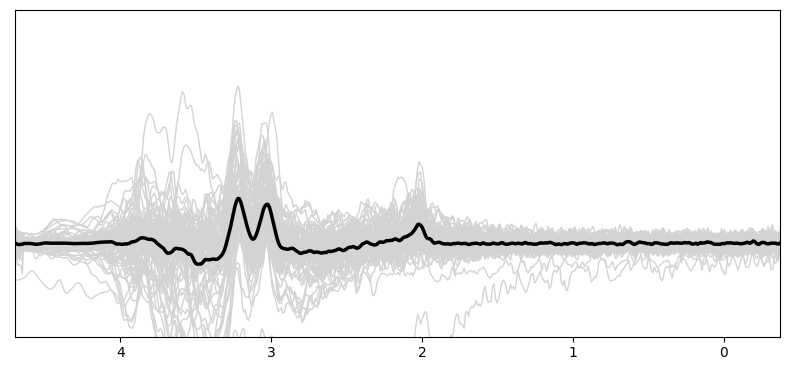

In [64]:
# --- Set black background and white axis text ---
plt.style.use('default')

N = len(coords_raw)
spectra_stack = []

# Collect spectra
for z, y, x in coords_raw[:N]:
    spectra_stack.append(spectral_arr[z, y, x, :])

spectra_stack = np.stack(spectra_stack)  # shape (N, 512)
mean_spectrum = spectra_stack.mean(axis=0)

# Plot all spectra in light gray
plt.figure(figsize=(8, 4))
for spectrum in spectra_stack:
    plt.plot(spectra_xaxis, spectrum, color='lightgray', linewidth=1.0)

# Overlay average spectrum in bright white
plt.plot(spectra_xaxis, mean_spectrum, color='black', linewidth=2.5, label='Mean')

plt.xlabel("ppm", color='white')
plt.xlim(spectra_xaxis.max(), spectra_xaxis.min())  # invert ppm axis
plt.yticks([])  # remove y-axis ticks
plt.ylim(-2000, 5000)  # ← your y-axis range
plt.tight_layout()
plt.show()

In [28]:
import pickle

# 1) Path to your pickle file
pickle_path = r"E:\ArtifactRemovalProject\data\ratings\aggregate_data\spectral_test_20250423_1640.pkl"

# 2) Load the pickle
with open(pickle_path, "rb") as f:
    data = pickle.load(f)

# 3) Inspect what you’ve got
if isinstance(data, dict):
    print("Keys in pickle:", list(data.keys()))
else:
    print("Loaded object is a", type(data))

# 3) Inspect the first element
first = data[0]
print("Type of first element:", type(first))

# 4) If it’s a dict, show its keys
if isinstance(first, dict):
    print("Keys in element[0]:", list(first.keys()))
# If it’s a custom object, show its attributes
elif hasattr(first, "__dict__"):
    print("Attributes on element[0]:", list(vars(first).keys()))
else:
    # Fallback: pretty-print a small slice
    import pprint
    pprint.pprint(first, depth=2)


Loaded object is a <class 'list'>
Type of first element: <class 'dict'>
Keys in element[0]: ['unique_id', 'spectral_sampling', 'spectral_siref_sampling', 'raw_spectrum', 'water_siref', 'midas_fit', 'nnfit', 'subject_id', 'study_date', 'study_folder', 'slice_folder', 'assigned_raters', 'consensus_rating']


In [33]:
spectral_sampling_list = [d["spectral_sampling"] for d in data]
spectral_sampling_list[2]

{'hz_per_ppm': 123.258107,
 'spec_pts': 512,
 'freq_offset': -2.53533,
 'chem_shift_ref': 4.7,
 'spec_width': 625.0,
 'hz_per_pt': 1.220703125,
 'ppm_range': 5.07066038260672,
 'ppm_per_pt': 0.00990363355977875,
 'center_ppm': 2.16467,
 'left_edge_ppm': 4.70000019130336}

In [34]:
import json
# Step 1: Keys to average (float-valued fields only)
keys_to_average = [
    'hz_per_ppm', 'spec_pts', 'freq_offset', 'chem_shift_ref', 'spec_width',
    'hz_per_pt', 'ppm_range', 'ppm_per_pt', 'center_ppm', 'left_edge_ppm'
]

# Step 2: Stack values for each key
averaged_sampling = {}
for key in keys_to_average:
    values = [d[key] for d in spectral_sampling_list]
    averaged_sampling[key] = float(np.mean(values))

# Step 3: Save to a JSON file
output_path = "avg_spectral_sampling.json"
with open(output_path, "w") as f:
    json.dump(averaged_sampling, f, indent=4)

print(f"Averaged sampling info saved to {output_path}")

Averaged sampling info saved to avg_spectral_sampling.json


In [ ]:
qmap_path = r"E:\ArtifactRemovalProject\data\modelinference\DOSEESC_EM09\11.20.2018\qmap.npy"
qmap = np.load(qmap_path)

# mask 1: 1 where arr ≥ 2, else 0
mask_ge2 = (qmap >= 2).astype(np.uint8)   # or .astype(int)
# mask 2: 1 where arr == 4, else 0
mask_eq4 = (qmap == 4).astype(np.uint8)

[0 1 2 4]


(32, 64, 64)


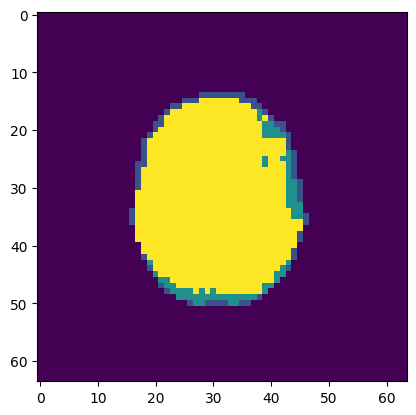

In [15]:
print(qmap.shape)
plt.imshow(qmap[16,:,:])

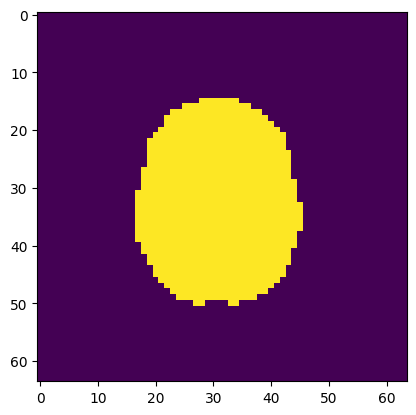

In [17]:
plt.imshow(mask_ge2[16,:,:])

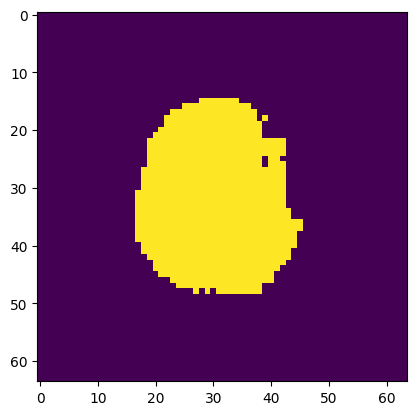

In [19]:
plt.imshow(mask_eq4[16,:,:])